In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from prophet import Prophet
import optuna
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

RANDOM_SEED = 2

EDA


In [2]:
df_basic = pd.read_parquet("dataset.parquet")

In [3]:
df_basic.head(3)

,sintez_group,posting_date,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
168241,ЗРА_3_100_40,2017-01-01,0,0.0,0,0.0,968.0
168242,ЗРА_3_100_40,2017-01-02,0,0.0,0,0.0,968.0
168243,ЗРА_3_100_40,2017-01-03,0,0.0,0,0.0,968.0


In [4]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6081 entries, 168241 to 318238
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sintez_group        6081 non-null   object 
 1   posting_date        6081 non-null   object 
 2   inc_bmu_fact_count  6081 non-null   int64  
 3   inc_bmu_sum         6081 non-null   float64
 4   out_bmu_fact_count  6081 non-null   int64  
 5   out_bmu_sum         6081 non-null   float64
 6   stock_sum           6081 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 380.1+ KB


In [5]:
df_basic.describe().T

,count,mean,std,min,25%,50%,75%,max
inc_bmu_fact_count,6081.0,0.375596,1.489775,0.0,0.0,0.0,0.0,34.0
inc_bmu_sum,6081.0,1.948035,9.618458,0.0,0.0,0.0,0.0,169.0
out_bmu_fact_count,6081.0,1.160664,3.663790,0.0,0.0,0.0,1.0,59.0
out_bmu_sum,6081.0,2.201118,8.123522,0.0,0.0,0.0,1.0,189.0
stock_sum,6081.0,804.732939,435.198333,200.0,471.0,701.0,1077.0,1991.0


In [6]:
df_basic["sintez_group"].unique()

array(['ЗРА_3_100_40', 'ЗРА_3_150_40', 'ЗРА_3_50_16'], dtype=object)

In [7]:
df_basic["posting_date"] = pd.to_datetime(df_basic["posting_date"], format="%Y-%m-%d")
min(df_basic["posting_date"]), max(df_basic["posting_date"])

(Timestamp('2017-01-01 00:00:00'), Timestamp('2022-07-20 00:00:00'))

In [8]:
df_basic.isnull().sum()

sintez_group          0
posting_date          0
inc_bmu_fact_count    0
inc_bmu_sum           0
out_bmu_fact_count    0
out_bmu_sum           0
stock_sum             0
dtype: int64

In [9]:
num_cols = [
    "inc_bmu_fact_count",
    "inc_bmu_sum",
    "out_bmu_fact_count",
    "stock_sum",
]

cat_cols = [
    "sintez_group",
]

dates = "posting_date"

feature_cols = num_cols + cat_cols
target_col = "out_bmu_sum"

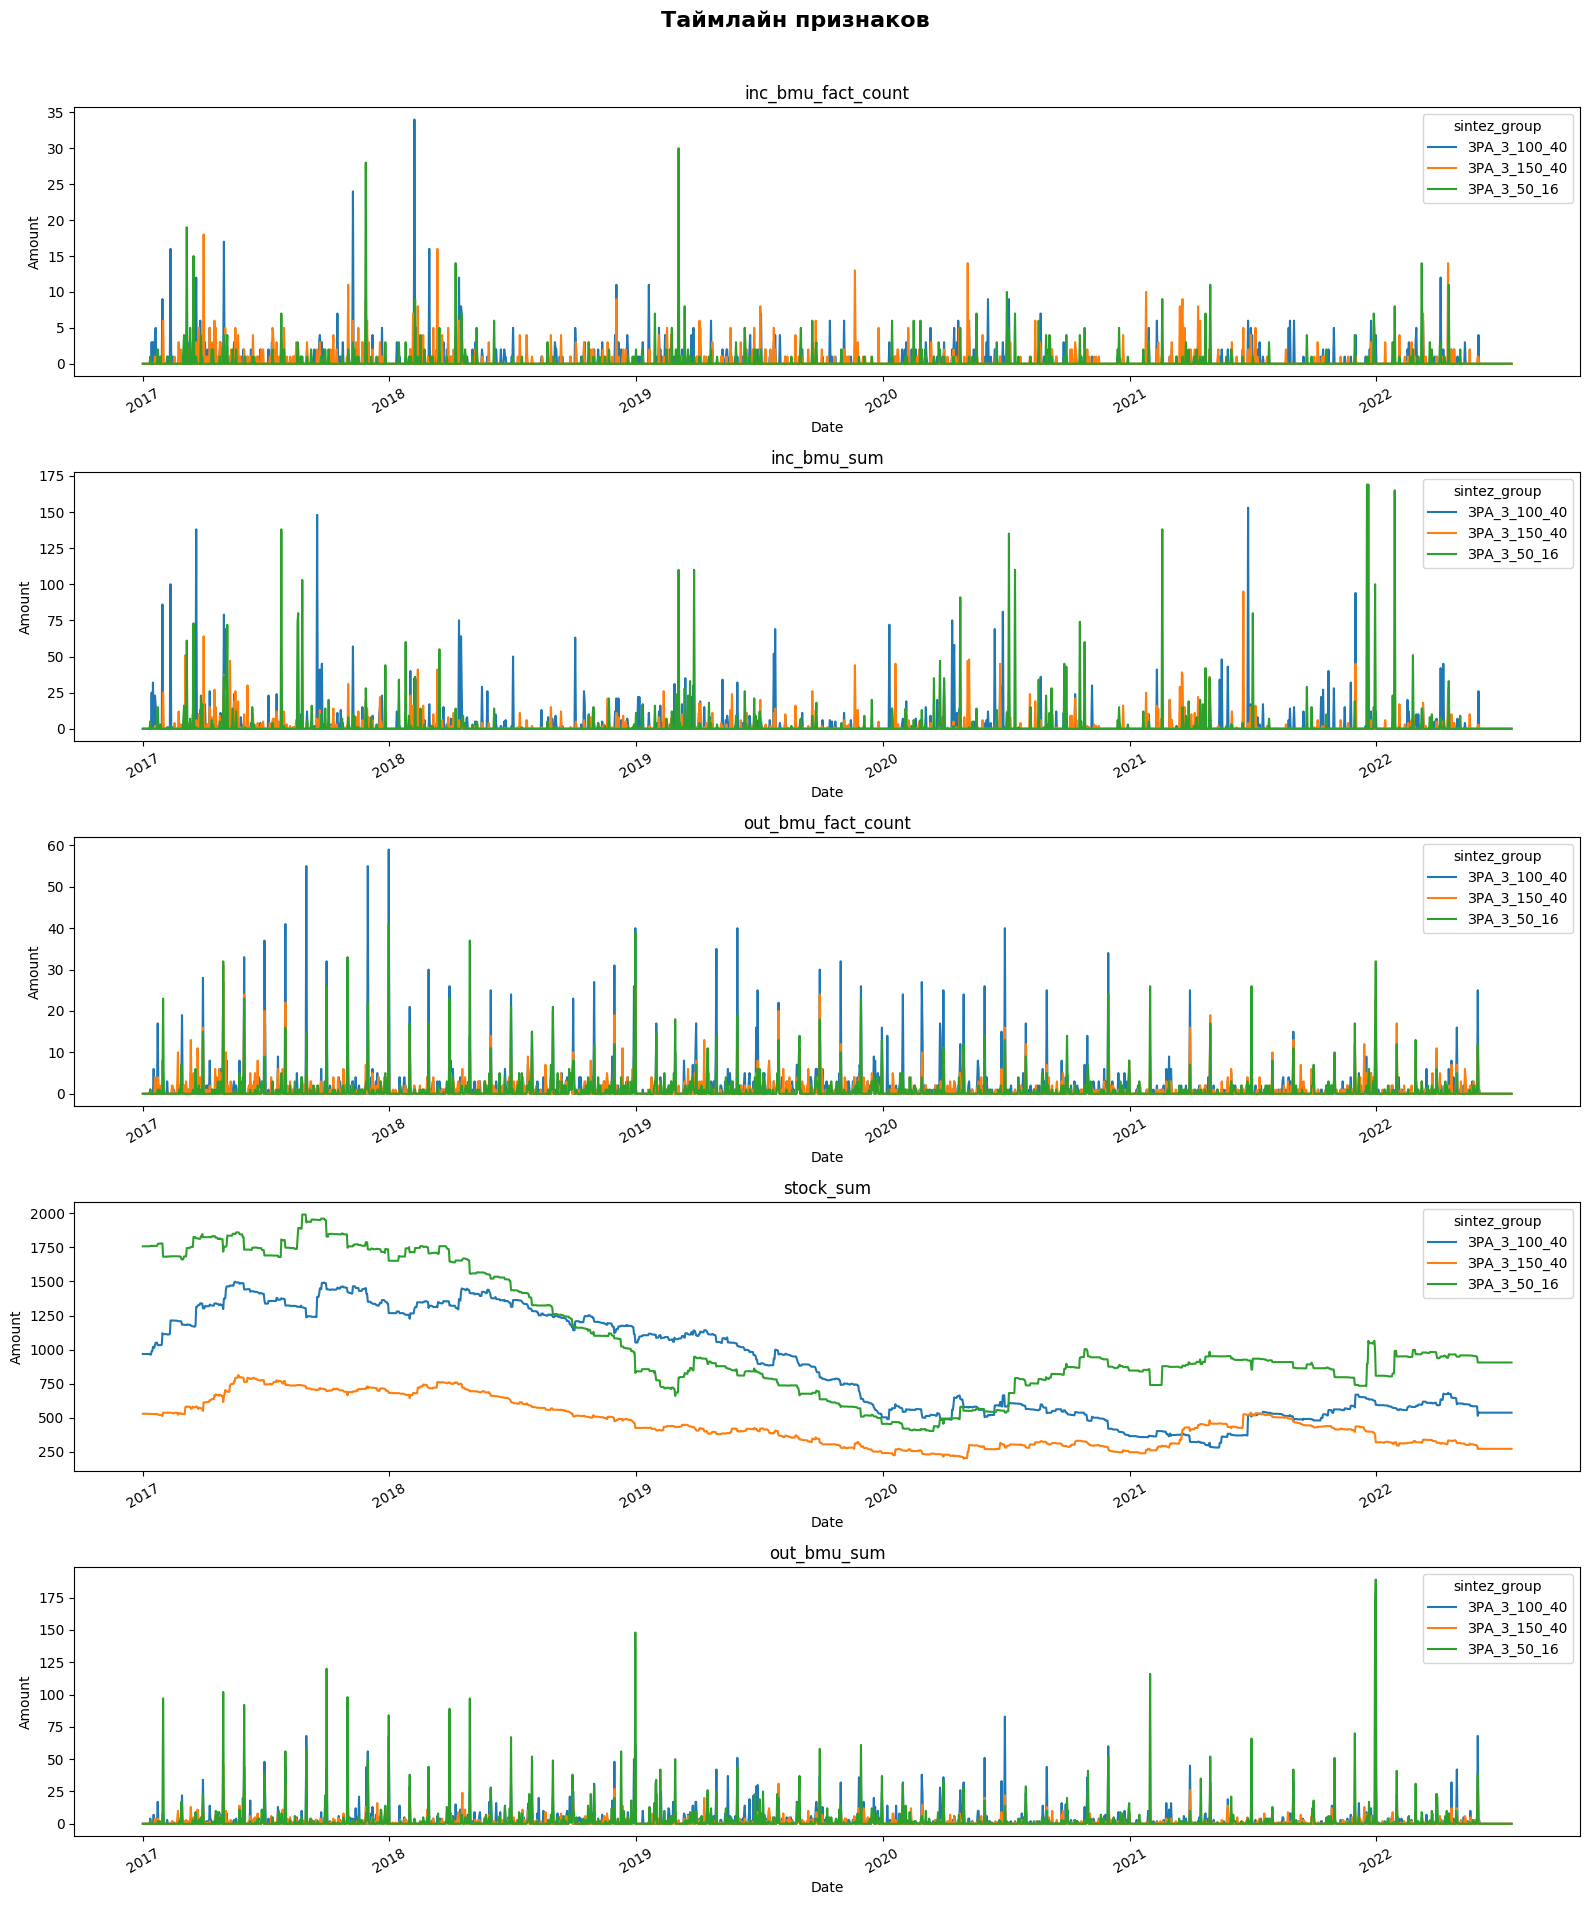

In [10]:
fig, ax = plt.subplots(5, 1, figsize=(16, 20), squeeze=False)

ax = ax.ravel()
for idx, col in enumerate(num_cols + [target_col]):
    ax[idx].set_title(col)
    sns.lineplot(
        data=df_basic.reset_index(),
        x="posting_date",
        y=col,
        hue="sintez_group",
        ax=ax[idx],
    )
    ax[idx].tick_params("x", labelrotation=30)
    ax[idx].set_ylabel("Amount")
    ax[idx].set_xlabel("Date")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Таймлайн признаков", fontsize=16, fontweight="bold")
fig.show()

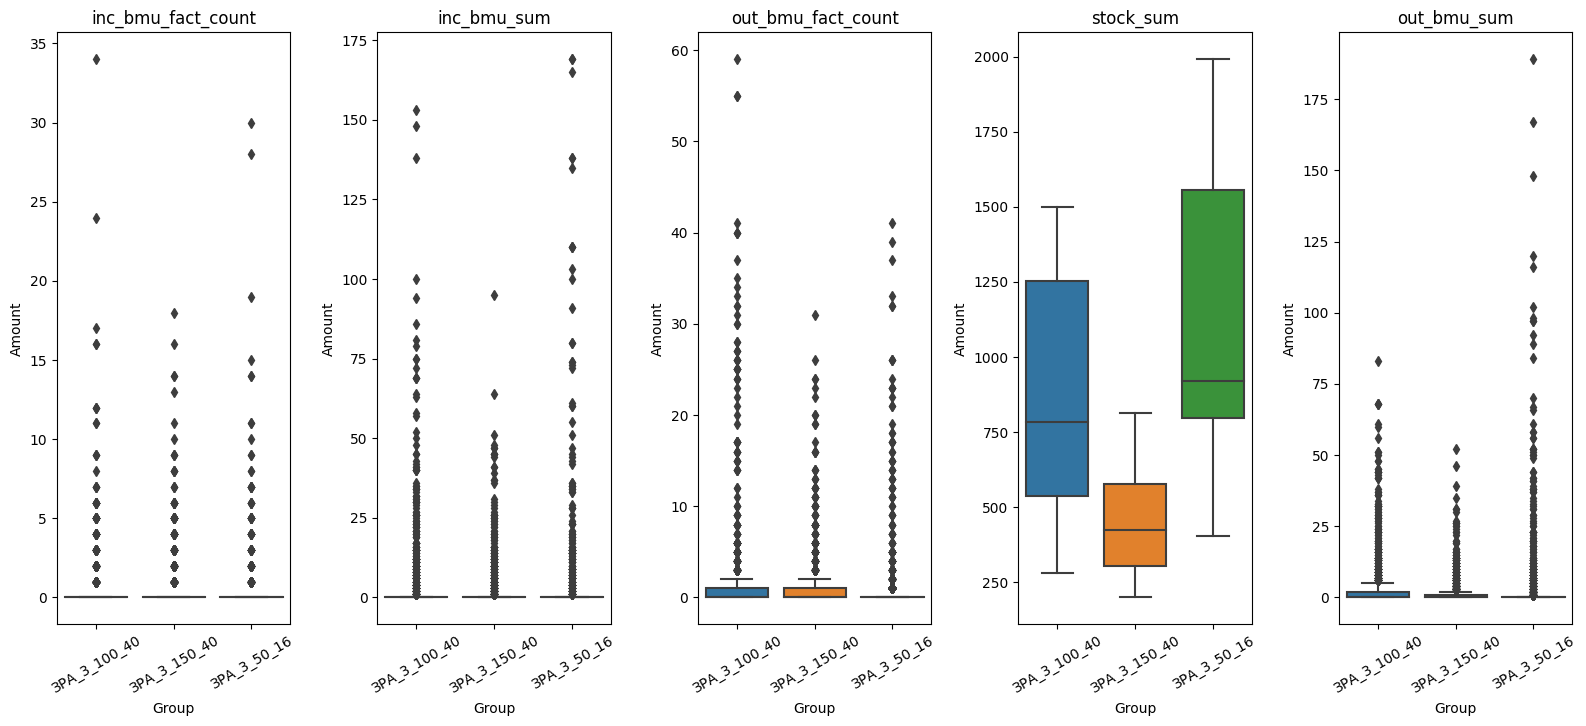

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(16, 8))

ax = ax.ravel()
for idx, col in enumerate(num_cols + [target_col]):
    ax[idx].set_title(col)
    sns.boxplot(
        data=df_basic,
        x="sintez_group",
        y=col,
        ax=ax[idx],
    )
    ax[idx].tick_params("x", labelrotation=30)
    ax[idx].set_ylabel("Amount")
    ax[idx].set_xlabel("Group")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

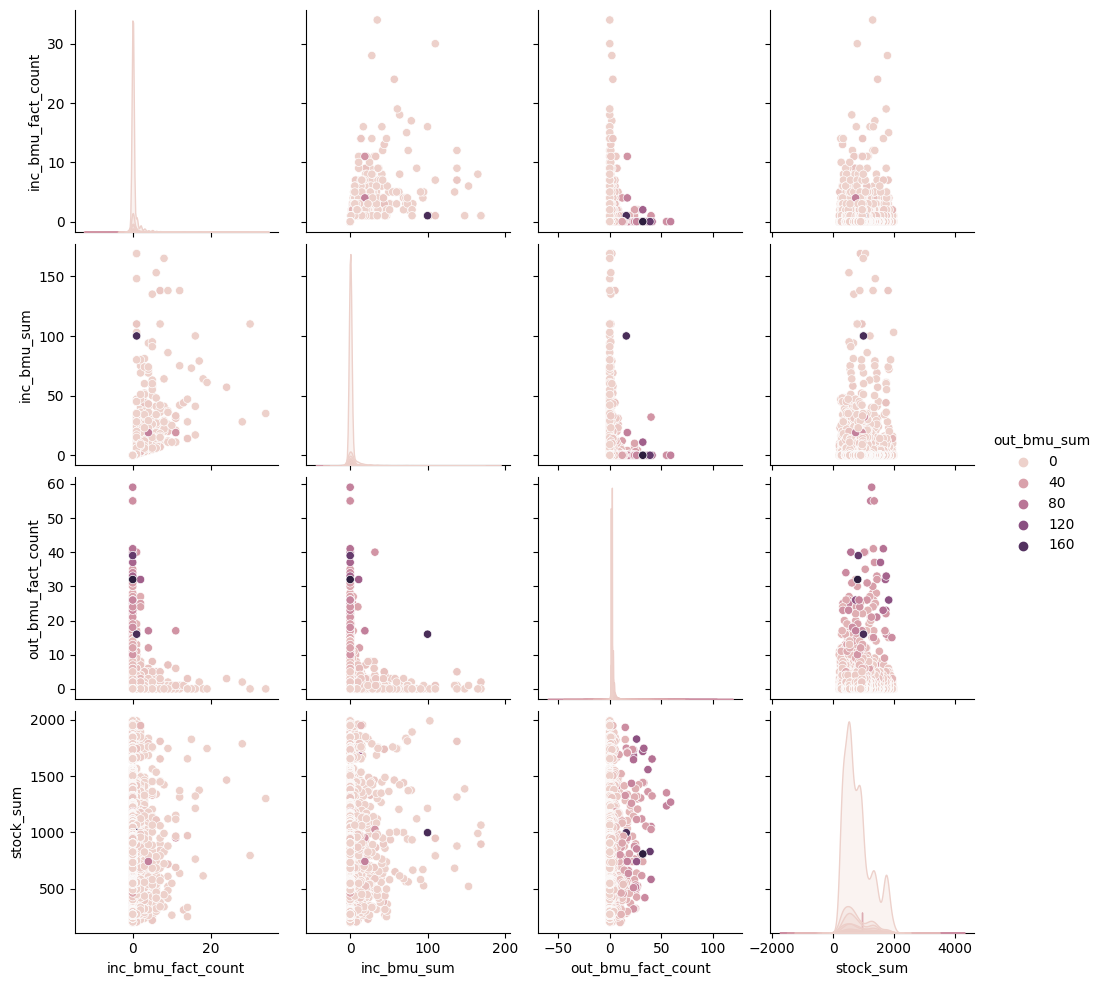

In [12]:
sns.pairplot(df_basic, hue=target_col)
plt.show()

Реализуем следующую архитектуру:

Бустинг на выбранных фичах -> генерация фичей с prophet -> файнтюнинг с optuna -> генерация прогнозов фичей с prophet -> прогноз модели по сгенерированным фичам.

Так как прогнозы нужны помесячно, построим 2 модели - с агрегацией по месяцам и без нее. Так как данные обладают явными пиками, и, в тоже время, наблюдается большое количество около нулевых значений, то MAE подходит плохо. Так как групп несколько, в качестве метрики будем использовать MultiRMSE.


Попробуем сгруппировать данные по месяцам


In [13]:
df = df_basic.copy()
df = (
    df.groupby(
        [df["posting_date"].dt.to_period("m"), df["sintez_group"]],
        as_index=[True, False],
    )
    .agg(
        inc_bmu_fact_count=("inc_bmu_fact_count", "sum"),
        inc_bmu_sum=("inc_bmu_sum", "sum"),
        out_bmu_fact_count=("out_bmu_fact_count", "sum"),
        out_bmu_sum=("out_bmu_sum", "sum"),
        stock_sum_mean=("stock_sum", "mean"),
        stock_sum_last=("stock_sum", "last"),
    )
    .reset_index()
)

In [14]:
df = df.set_index(df.posting_date).drop("posting_date", axis=1)

In [15]:
df.head()

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum_mean,stock_sum_last
posting_date,,,,,,,
2017-01,ЗРА_3_100_40,25,184.0,32,38.0,1008.451613,1114.0
2017-01,ЗРА_3_150_40,8,29.0,20,21.0,527.129032,538.0
2017-01,ЗРА_3_50_16,5,27.0,26,103.0,1761.709677,1682.0
2017-02,ЗРА_3_100_40,19,104.0,31,35.0,1175.392857,1183.0
2017-02,ЗРА_3_150_40,6,19.0,25,28.0,535.250000,529.0


In [16]:
num_cols = list(
    df.loc[:, df.columns.difference(["out_bmu_sum", "sintez_group", "posting_date"])]
)

In [17]:
for col in num_cols:
    df[f"{col}_ma_3m"] = df.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    df[f"{col}_ma_1y"] = df.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(12, min_periods=1).mean()
    )

In [18]:
df.tail(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum_mean,stock_sum_last,inc_bmu_fact_count_ma_3m,inc_bmu_fact_count_ma_1y,inc_bmu_sum_ma_3m,inc_bmu_sum_ma_1y,out_bmu_fact_count_ma_3m,out_bmu_fact_count_ma_1y,stock_sum_last_ma_3m,stock_sum_last_ma_1y,stock_sum_mean_ma_3m,stock_sum_mean_ma_1y
posting_date,,,,,,,,,,,,,,,,,
2022-07,ЗРА_3_100_40,0,0.0,0,0.0,538.0,538.0,2.666667,8.750000,12.333333,49.166667,12.666667,23.333333,530.333333,551.916667,556.517204,568.037084
2022-07,ЗРА_3_150_40,0,0.0,0,0.0,273.0,273.0,1.333333,5.916667,5.000000,19.416667,12.333333,25.750000,272.666667,342.333333,283.936201,362.462078
2022-07,ЗРА_3_50_16,0,0.0,0,0.0,906.0,906.0,0.666667,7.000000,3.000000,73.416667,6.333333,18.333333,906.000000,885.500000,921.849462,898.304788


In [19]:
# df["day"] = df["posting_date"].dt.day
df["month"] = df.index.month
df["quarter"] = df.index.quarter
# df["year"] = df.index.year
# df["week_of_year"] = df["posting_date"].dt.isocalendar().week.astype(int)
# df["day_of_week"] = df["posting_date"].dt.dayofweek

df.head(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum_mean,stock_sum_last,inc_bmu_fact_count_ma_3m,inc_bmu_fact_count_ma_1y,inc_bmu_sum_ma_3m,inc_bmu_sum_ma_1y,out_bmu_fact_count_ma_3m,out_bmu_fact_count_ma_1y,stock_sum_last_ma_3m,stock_sum_last_ma_1y,stock_sum_mean_ma_3m,stock_sum_mean_ma_1y,month,quarter
posting_date,,,,,,,,,,,,,,,,,,,
2017-01,ЗРА_3_100_40,25,184.0,32,38.0,1008.451613,1114.0,25.0,25.0,184.0,184.0,32.0,32.0,1114.0,1114.0,1008.451613,1008.451613,1,1
2017-01,ЗРА_3_150_40,8,29.0,20,21.0,527.129032,538.0,8.0,8.0,29.0,29.0,20.0,20.0,538.0,538.0,527.129032,527.129032,1,1
2017-01,ЗРА_3_50_16,5,27.0,26,103.0,1761.709677,1682.0,5.0,5.0,27.0,27.0,26.0,26.0,1682.0,1682.0,1761.709677,1761.709677,1,1


In [20]:
num_cols = list(
    df.loc[:, df.columns.difference(["out_bmu_sum", "sintez_group", "posting_date"])]
)

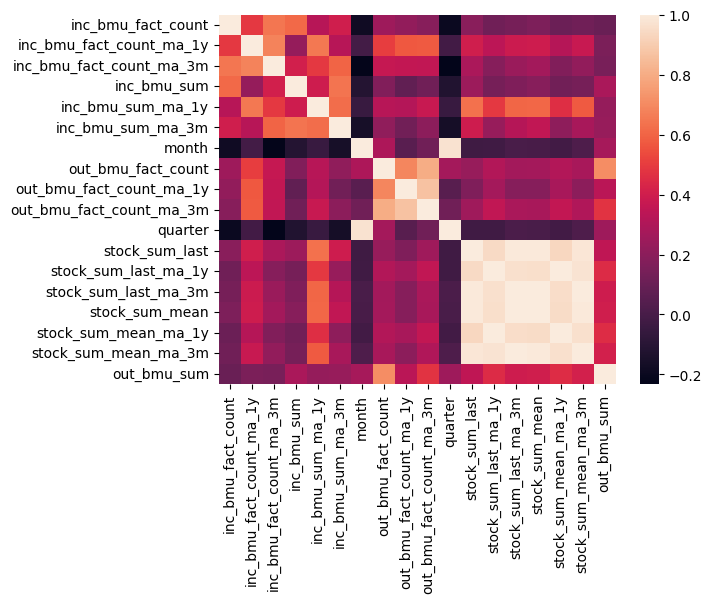

In [21]:
sns.heatmap(df[num_cols + [target_col]].corr())
plt.show()

Базовая модель бустинга


In [22]:
def ts_model(df, granularity="month"):
    """
    Train a time series model using CatBoostRegressor
    """
    X = df.drop(target_col, axis=1).copy()
    y = df[target_col].copy()
    X_train, X_test = (
        X.iloc[: -int(0.2 * (len(df))), :],
        X.iloc[-int(0.2 * (len(df))) :, :],
    )
    y_train, y_test = (
        y.iloc[: -int(0.2 * (len(df)))],
        y.iloc[-int(0.2 * (len(df))) :],
    )

    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.01,
        loss_function="MultiRMSE",
        random_seed=RANDOM_SEED,
    )
    model.fit(
        X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test), silent=True
    )
    predictions = model.predict(X_test)
    """
    Plot the results
    """
    rmse = np.round(mean_squared_error(y_test, predictions), 3)

    fig = plt.figure(figsize=(16, 6))
    plt.title(f"RMSE {rmse}")
    if granularity == "month":
        plt.plot(y_test.index.to_timestamp(), y_test.values)
        plt.plot(pd.Series(predictions, index=y_test.index.to_timestamp()))
    else:
        plt.plot(y_test)
        plt.plot(pd.Series(predictions, index=y_test.index))
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend(labels=["Real", "Pred"])
    plt.grid()
    plt.show()

    df_importance = pd.DataFrame(
        {
            "feature": X_test.columns,
            "importance": model.get_feature_importance(),
        }
    ).sort_values(by="importance", ascending=False)

    plt.title("Importances", fontsize=16)
    sns.barplot(x=df_importance.importance, y=df_importance.feature)
    plt.show()

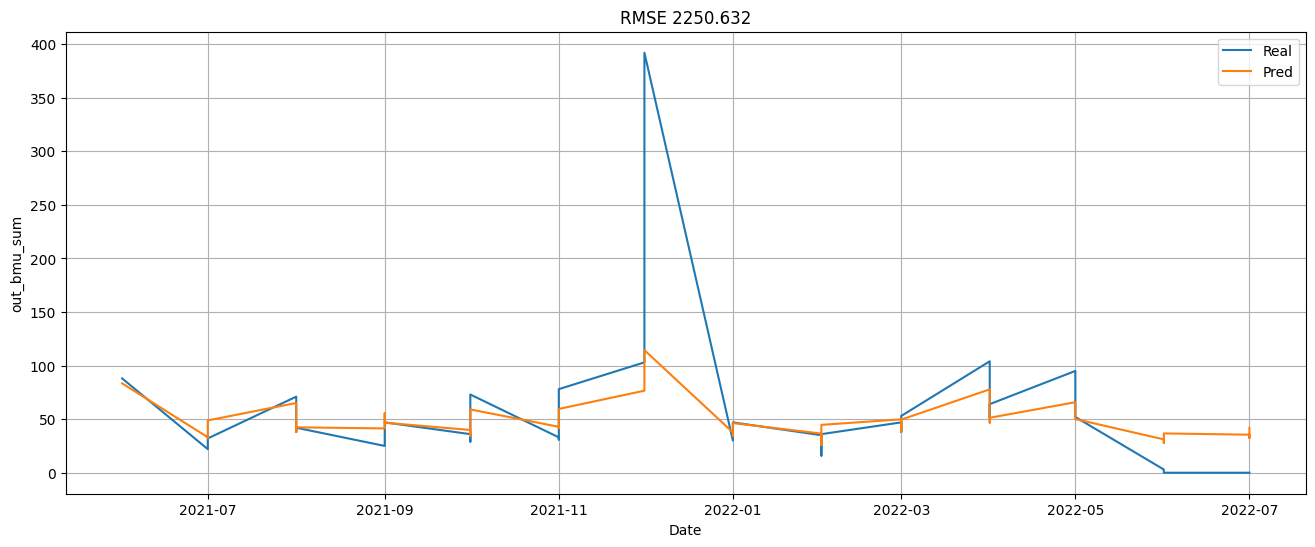

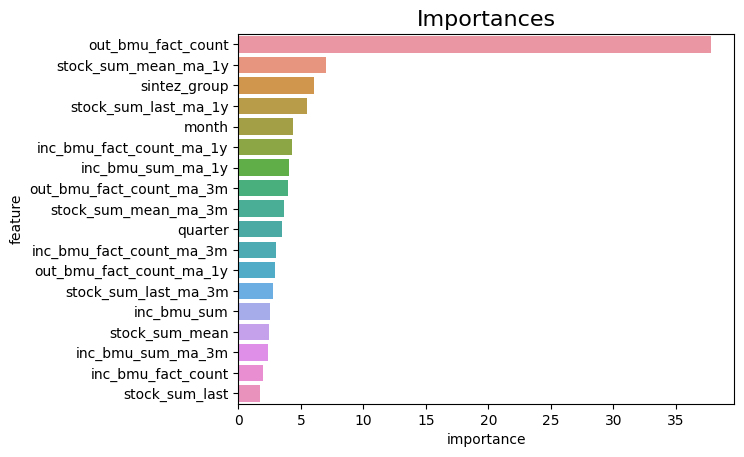

In [23]:
ts_model(df, granularity="month")

Реализуем генерацию фичей с prophet


In [24]:
def prophet_fc(df, granularity="month", show_prop_plot=True):
    """
    Function to forecast features using prophet.
    """
    temp_df = df.copy()
    temp_df = temp_df.reset_index()
    total_predictions = pd.DataFrame()
    for group in df["sintez_group"].unique():
        pred_df = temp_df[temp_df["sintez_group"] == group].copy()
        pred_df = pred_df[["posting_date", "out_bmu_sum"]]
        pred_df["posting_date"] = pd.to_datetime(pred_df["posting_date"].astype(str))
        pred_df.rename(columns={"posting_date": "ds", "out_bmu_sum": "y"}, inplace=True)

        # temp_df = temp_df[["posting_date", "out_bmu_sum"]]
        # temp_df["posting_date"] = pd.to_datetime(temp_df["posting_date"].astype(str))
        # temp_df.rename(columns={"posting_date": "ds", "out_bmu_sum": "y"}, inplace=True)

        # train, test = (
        #     temp_df.iloc[: -int(0.2 * (len(df))), :],
        #     temp_df.iloc[-int(0.2 * (len(df))) :, :],
        # )

        if granularity == "month":
            forecast = Prophet(
                growth="linear",
                seasonality_mode="multiplicative",
                interval_width=0.95,
            )
        else:
            forecast = Prophet(
                growth="linear",
                seasonality_mode="additive",
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
            )

        # forecast.fit(train)
        # predictions_train = forecast.predict(train.drop("y", axis=1))
        # predictions_test = forecast.predict(test.drop("y", axis=1))
        # predictions = pd.concat([predictions_train, predictions_test], axis=0)
        forecast.fit(pred_df)
        predictions = forecast.predict(pred_df)
        predictions["sintez_group"] = group
        total_predictions = pd.concat(
            [total_predictions, predictions], axis=0, ignore_index=True
        )

    if show_prop_plot:
        future = forecast.make_future_dataframe(periods=365)
        fcst = forecast.predict(future)
        fcst.head()
        forecast.plot(fcst)

    if granularity == "month":
        total_predictions["ds"] = total_predictions["ds"].dt.to_period("M")

    return total_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,sintez_group
0,2017-01,118.488549,-0.344278,95.746566,118.488549,118.488549,-0.604703,-0.604703,-0.604703,-0.604703,-0.604703,-0.604703,0.0,0.0,0.0,46.838192,ЗРА_3_100_40
1,2017-02,117.547545,14.114722,104.959352,117.547545,117.547545,-0.509455,-0.509455,-0.509455,-0.509455,-0.509455,-0.509455,0.0,0.0,0.0,57.662368,ЗРА_3_100_40
2,2017-03,116.697605,60.636873,151.857746,116.697605,116.697605,-0.094066,-0.094066,-0.094066,-0.094066,-0.094066,-0.094066,0.0,0.0,0.0,105.720338,ЗРА_3_100_40
3,2017-04,115.756601,82.002246,168.199631,115.756601,115.756601,0.069052,0.069052,0.069052,0.069052,0.069052,0.069052,0.0,0.0,0.0,123.749803,ЗРА_3_100_40
4,2017-05,114.845952,60.292455,152.603463,114.845952,114.845952,-0.083899,-0.083899,-0.083899,-0.083899,-0.083899,-0.083899,0.0,0.0,0.0,105.210453,ЗРА_3_100_40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2022-03,70.860089,-29.831408,145.638558,70.860089,70.860089,-0.280909,-0.280909,-0.280909,-0.280909,-0.280909,-0.280909,0.0,0.0,0.0,50.954873,ЗРА_3_50_16
197,2022-04,70.407554,-13.219674,162.357197,70.407554,70.407554,0.096056,0.096056,0.096056,0.096056,0.096056,0.096056,0.0,0.0,0.0,77.170655,ЗРА_3_50_16
198,2022-05,69.969618,-41.803626,133.137416,69.969618,69.969618,-0.295034,-0.295034,-0.295034,-0.295034,-0.295034,-0.295034,0.0,0.0,0.0,49.326188,ЗРА_3_50_16
199,2022-06,69.517083,-45.756591,135.756454,69.517083,69.517083,-0.418019,-0.418019,-0.418019,-0.418019,-0.418019,-0.418019,0.0,0.0,0.0,40.457608,ЗРА_3_50_16


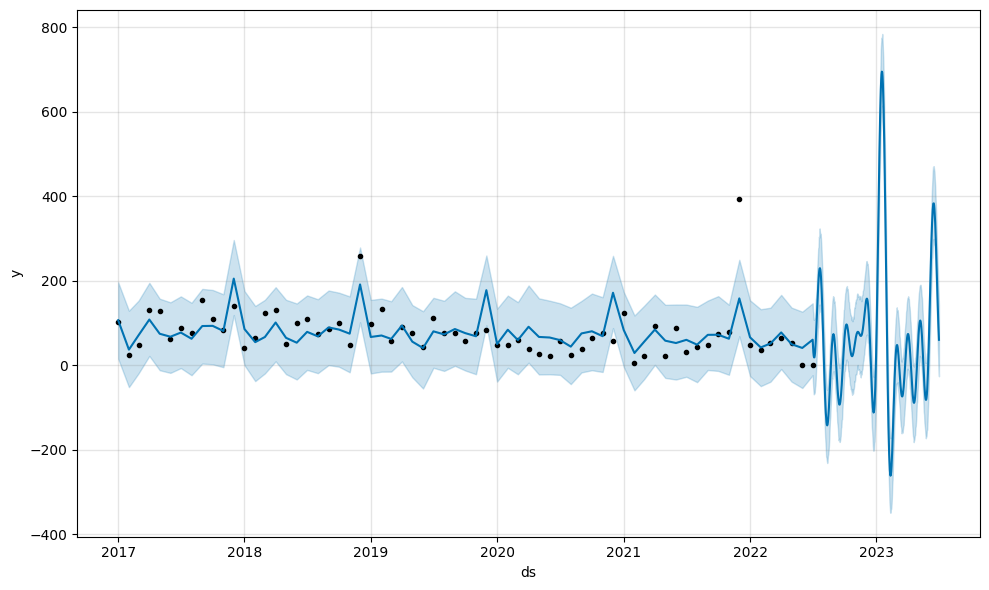

In [25]:
prophet_fc(df, granularity="month", show_prop_plot=True)

Модель с учетом фичей prophet


In [26]:
def prep_df(df, granularity="month"):
    """
    Prepares the dataframe with prophet features.
    """
    prop_feat = prophet_fc(df, granularity=granularity, show_prop_plot=False)
    data = df.copy()
    data.reset_index(inplace=True)

    data = pd.merge(
        data,
        prop_feat,
        left_on=["posting_date", "sintez_group"],
        right_on=["ds", "sintez_group"],
        how="inner",
    ).sort_values(by="posting_date")
    data.drop("ds", axis=1, inplace=True)
    data.set_index("posting_date", inplace=True)

    return data

In [27]:
def ts_model_with_prophet(df, granularity="month"):
    """
    Train a time series model using CatBoostRegressor with prophet features.
    """
    data = prep_df(df, granularity=granularity)

    X = data.drop(target_col, axis=1).copy()
    y = data[target_col].copy()

    X_train, X_test = (
        X.iloc[: -int(0.2 * (len(df))), :],
        X.iloc[-int(0.2 * (len(df))) :, :],
    )
    y_train, y_test = (
        y.iloc[: -int(0.2 * (len(df)))],
        y.iloc[-int(0.2 * (len(df))) :],
    )

    model = CatBoostRegressor(
        iterations=1000,
        has_time=True,
        depth=6,
        learning_rate=0.01,
        loss_function="MultiRMSE",
        random_seed=RANDOM_SEED,
    )
    model.fit(
        X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test), silent=True
    )
    predictions = model.predict(X_test)
    """
    Plot the results
    """
    rmse = np.round(mean_squared_error(y_test, predictions), 3)

    fig = plt.figure(figsize=(10, 6))
    plt.title(f"RMSE {rmse}")
    if granularity == "month":
        plt.plot(y_test.index.to_timestamp(), y_test.values)
        plt.plot(pd.Series(predictions, index=y_test.index.to_timestamp()))
    else:
        plt.plot(y_test)
        plt.plot(pd.Series(predictions, index=y_test.index))
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend(labels=["Real", "Pred"])
    plt.grid()
    plt.show()

    df_importance = pd.DataFrame(
        {
            "feature": X_test.columns,
            "importance": model.get_feature_importance(),
        }
    ).sort_values(by="importance", ascending=False)

    plt.title("Importances")
    sns.barplot(x=df_importance.importance, y=df_importance.feature)
    plt.show()

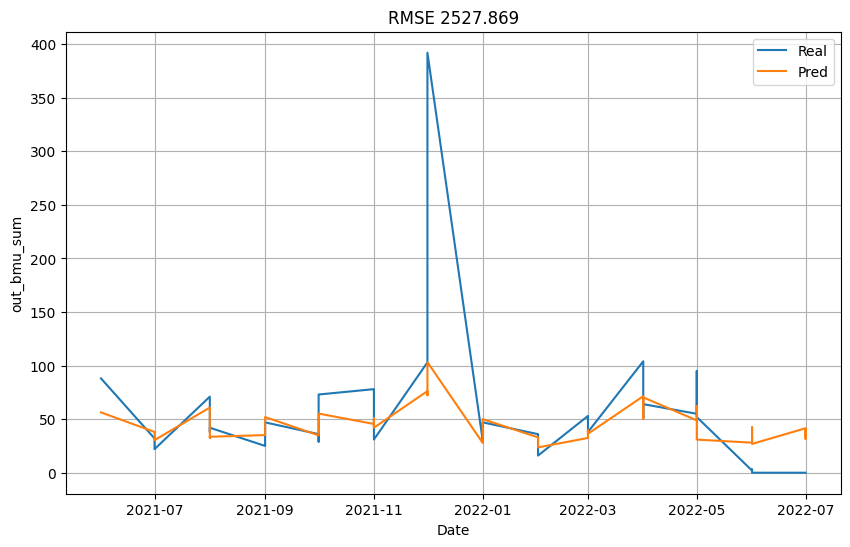

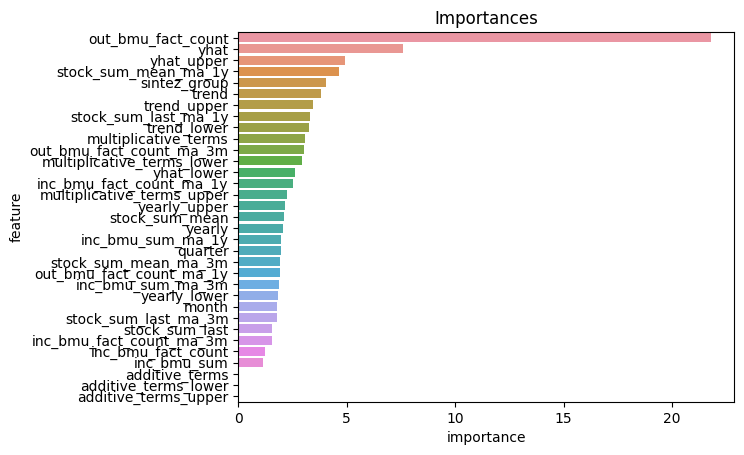

In [28]:
ts_model_with_prophet(df, granularity="month")

Построим то же самое подневно


In [29]:
df_daily = df_basic.copy()
df_daily = df_daily.set_index(df_daily.posting_date).drop("posting_date", axis=1)
num_cols = list(
    df_daily.loc[
        :, df_daily.columns.difference(["out_bmu_sum", "sintez_group", "posting_date"])
    ]
)
df_daily.head()

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum
posting_date,,,,,,
2017-01-01,ЗРА_3_100_40,0,0.0,0,0.0,968.0
2017-01-02,ЗРА_3_100_40,0,0.0,0,0.0,968.0
2017-01-03,ЗРА_3_100_40,0,0.0,0,0.0,968.0
2017-01-04,ЗРА_3_100_40,0,0.0,0,0.0,968.0
2017-01-05,ЗРА_3_100_40,0,0.0,0,0.0,968.0


In [30]:
for col in num_cols:
    df_daily[f"{col}_ma_30d"] = df_daily.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    df_daily[f"{col}_ma_90d"] = df_daily.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(90, min_periods=1).mean()
    )

In [31]:
df_daily["day"] = df_daily.index.day
df_daily["month"] = df_daily.index.month
df_daily["quarter"] = df_daily.index.quarter
df_daily["year"] = df_daily.index.year
df_daily["week_of_year"] = df_daily.index.isocalendar().week.astype(int)
df_daily["day_of_week"] = df_daily.index.dayofweek

df_daily.head(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum,inc_bmu_fact_count_ma_30d,inc_bmu_fact_count_ma_90d,inc_bmu_sum_ma_30d,inc_bmu_sum_ma_90d,out_bmu_fact_count_ma_30d,out_bmu_fact_count_ma_90d,stock_sum_ma_30d,stock_sum_ma_90d,day,month,quarter,year,week_of_year,day_of_week
posting_date,,,,,,,,,,,,,,,,,,,,
2017-01-01,ЗРА_3_100_40,0,0.0,0,0.0,968.0,0.0,0.0,0.0,0.0,0.0,0.0,968.0,968.0,1,1,1,2017,52,6
2017-01-02,ЗРА_3_100_40,0,0.0,0,0.0,968.0,0.0,0.0,0.0,0.0,0.0,0.0,968.0,968.0,2,1,1,2017,1,0
2017-01-03,ЗРА_3_100_40,0,0.0,0,0.0,968.0,0.0,0.0,0.0,0.0,0.0,0.0,968.0,968.0,3,1,1,2017,1,1


In [32]:
num_cols = list(
    df_daily.loc[
        :, df_daily.columns.difference(["out_bmu_sum", "sintez_group", "posting_date"])
    ]
)

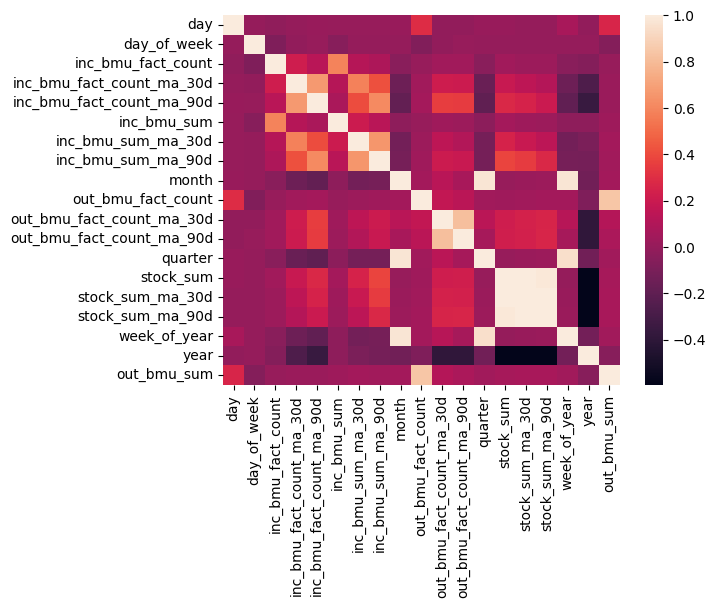

In [33]:
sns.heatmap(df_daily[num_cols + [target_col]].corr())
plt.show()

In [34]:
feature_cols = num_cols + cat_cols

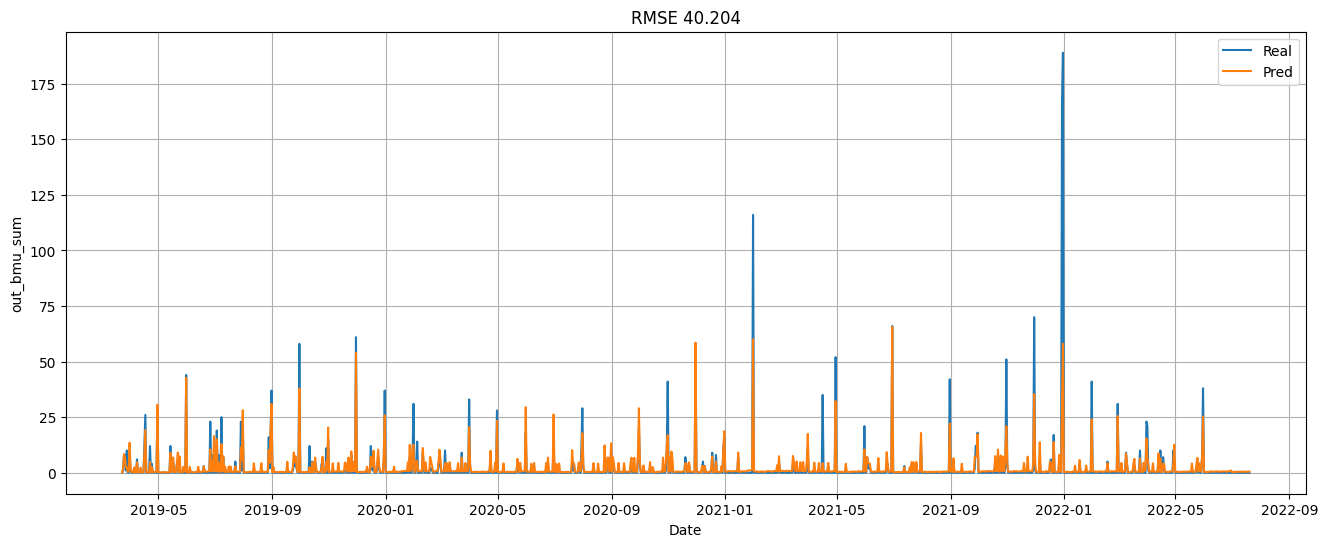

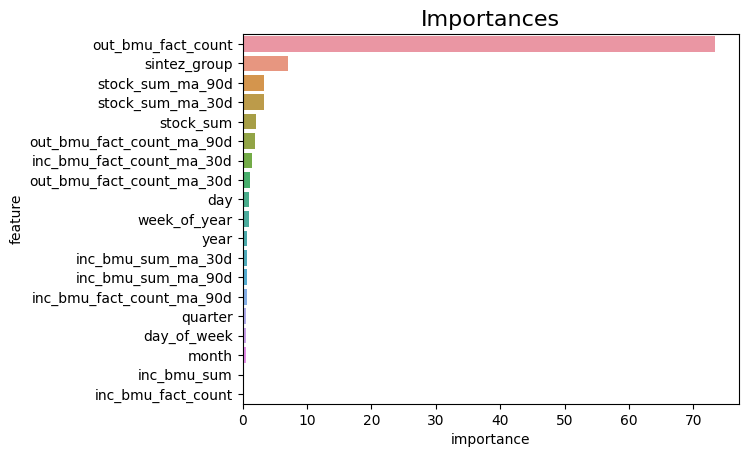

In [35]:
ts_model(df_daily, granularity="day")

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,sintez_group
0,2017-01-01,0.514311,-12.315389,15.893407,0.514311,0.514311,1.332198,1.332198,1.332198,2.057331,...,-1.473711,-1.473711,0.748579,0.748579,0.748579,0.0,0.0,0.0,1.846510,ЗРА_3_100_40
1,2017-01-02,0.515117,-10.423143,17.466059,0.515117,0.515117,3.054735,3.054735,3.054735,2.057331,...,0.317527,0.317527,0.679877,0.679877,0.679877,0.0,0.0,0.0,3.569852,ЗРА_3_100_40
2,2017-01-03,0.515922,-9.584882,18.652791,0.515922,0.515922,3.438036,3.438036,3.438036,2.057331,...,0.781297,0.781297,0.599408,0.599408,0.599408,0.0,0.0,0.0,3.953959,ЗРА_3_100_40
3,2017-01-04,0.516728,-10.027579,16.791743,0.516728,0.516728,2.596154,2.596154,2.596154,2.057331,...,0.031368,0.031368,0.507455,0.507455,0.507455,0.0,0.0,0.0,3.112882,ЗРА_3_100_40
4,2017-01-05,0.517534,-10.300526,17.216236,0.517534,0.517534,3.010965,3.010965,3.010965,2.057331,...,0.549021,0.549021,0.404613,0.404613,0.404613,0.0,0.0,0.0,3.528499,ЗРА_3_100_40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6076,2022-07-16,-0.209888,-22.223694,22.226614,-0.209888,-0.209888,1.504361,1.504361,1.504361,2.509391,...,-0.667746,-0.667746,-0.337285,-0.337285,-0.337285,0.0,0.0,0.0,1.294473,ЗРА_3_50_16
6077,2022-07-17,-0.209414,-21.345193,24.653818,-0.209414,-0.209414,1.029427,1.029427,1.029427,2.509391,...,-1.098186,-1.098186,-0.381778,-0.381778,-0.381778,0.0,0.0,0.0,0.820013,ЗРА_3_50_16
6078,2022-07-18,-0.208940,-19.296667,25.946044,-0.208940,-0.208940,2.990420,2.990420,2.990420,2.509391,...,0.904724,0.904724,-0.423696,-0.423696,-0.423696,0.0,0.0,0.0,2.781479,ЗРА_3_50_16
6079,2022-07-19,-0.208467,-18.993214,23.873016,-0.208467,-0.208467,2.531128,2.531128,2.531128,2.509391,...,0.483559,0.483559,-0.461822,-0.461822,-0.461822,0.0,0.0,0.0,2.322661,ЗРА_3_50_16


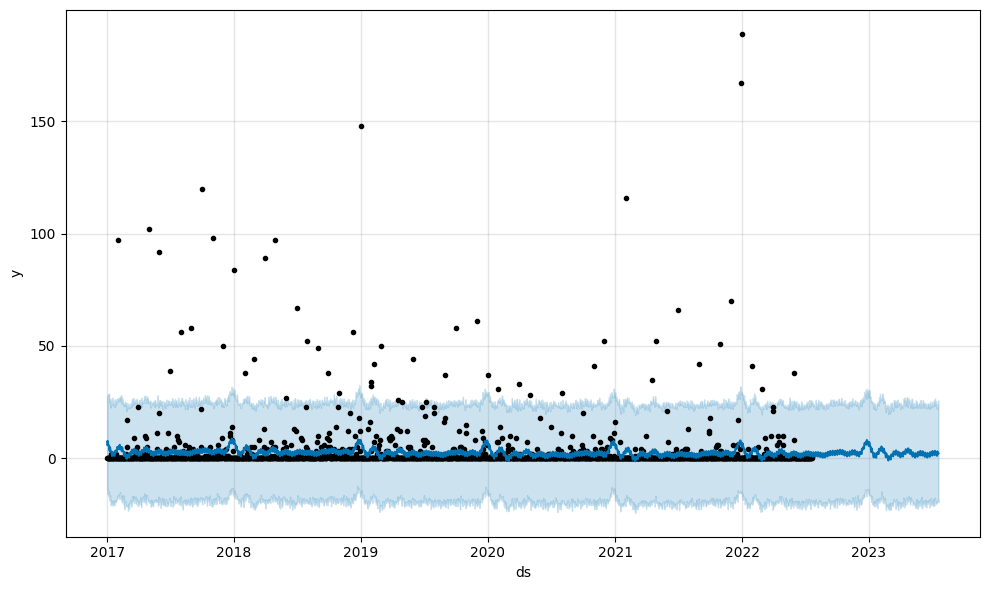

In [36]:
prophet_fc(df_daily, granularity="day", show_prop_plot=True)

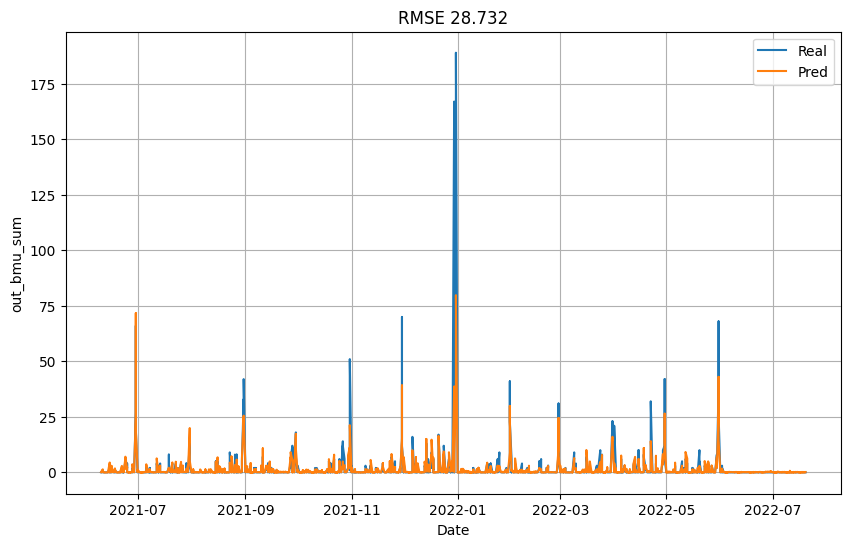

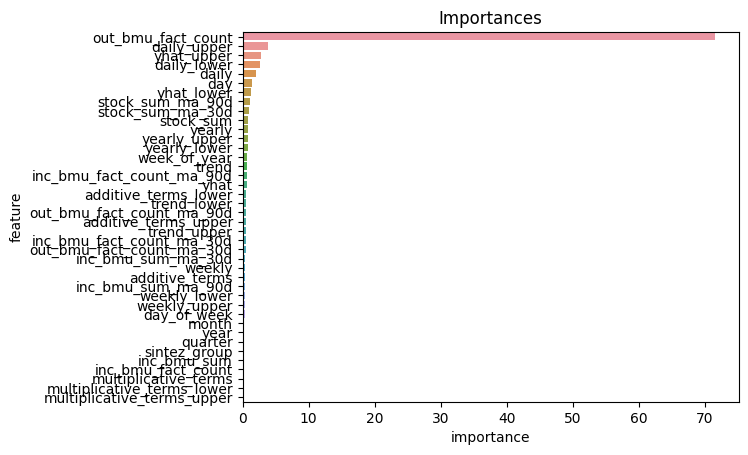

In [37]:
ts_model_with_prophet(df_daily, granularity="day")

Тюним гиперпараметры


Видно, что модель по дням дает более качественные прогнозы, тюнить будем только ее


In [38]:
df_final = prep_df(df_daily, granularity="day")

In [39]:
def objective(trial: optuna.Trial) -> float:
    """Objective function for Optuna."""
    X = df_final.drop(target_col, axis=1).copy()
    y = df_final[target_col].copy()
    X_train, X_test = (
        X.iloc[: -int(0.2 * (len(df))), :],
        X.iloc[-int(0.2 * (len(df))) :, :],
    )
    y_train, y_test = (
        y.iloc[: -int(0.2 * (len(df)))],
        y.iloc[-int(0.2 * (len(df))) :],
    )

    param = {
        "objective": trial.suggest_categorical(
            "objective",
            ["MultiRMSE"]
            #   , "RMSE", "MAE", "MAPE"]
        ),
        "iterations": trial.suggest_int("iterations", 300, 1200),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 100),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10.0, log=True),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type",
            ["Bayesian", "Bernoulli"]
            #    , "MVS"]
        ),
        "verbose": False,
        "random_state": RANDOM_SEED,
        "used_ram_limit": "8gb",
        "eval_metric": "MultiRMSE",
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        #  , log=True)

    model = CatBoostRegressor(cat_features=cat_cols, has_time=True, **param)

    pruning_callback = CatBoostPruningCallback(trial, "MultiRMSE")
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = model.predict(X_test)
    loss = mean_squared_error(y_test, preds)
    # loss = mean_absolute_error(y_test, preds)

    return loss

In [40]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
study_d = optuna.create_study(
    study_name="catboost_daily",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="minimize",
    sampler=sampler,
)
study_d.optimize(objective, n_trials=500, timeout=1200)

In [41]:
trial = study_d.best_trial
for item, value in trial.params.items():
    print(f"{item}: {value}")

objective: MultiRMSE
iterations: 655
depth: 7
learning_rate: 0.08536298450883573
colsample_bylevel: 0.40312604173214944
min_data_in_leaf: 45
l2_leaf_reg: 5.314064311161733e-05
boosting_type: Ordered
bootstrap_type: Bernoulli
subsample: 0.9248678811151524


In [42]:
best_model = CatBoostRegressor(
    cat_features=cat_cols,
    **trial.params,
    verbose=False,
)
best_model.fit(df_final.drop("out_bmu_sum", axis=1), df_final["out_bmu_sum"])
best_model.save_model("best_model.cbm")

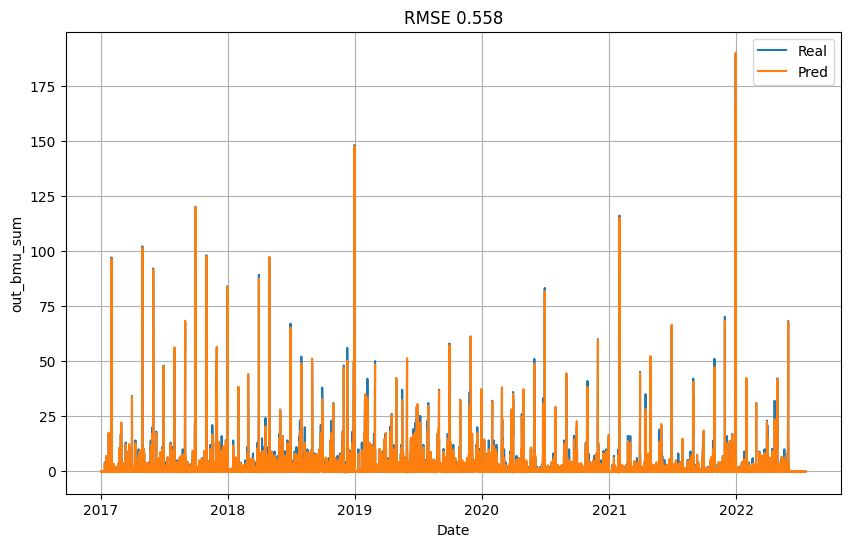

In [43]:
# X_test, y_test = (
#     df_final.drop(target_col, axis=1).iloc[-int(0.2 * (len(df_final))) :, :],
#     df_final[target_col].iloc[-int(0.2 * (len(df_final))) :],
# )
# predictions = best_model.predict(X_test)
# rmse = np.round(mean_squared_error(y_test, predictions), 3)


predictions = best_model.predict(df_final.drop(target_col, axis=1))
rmse = np.round(mean_squared_error(df_final[target_col], predictions), 3)

fig = plt.figure(figsize=(10, 6))
plt.title(f"RMSE {rmse}")
# plt.plot(y_test)
# plt.plot(pd.Series(predictions, index=y_test.index))
plt.plot(df_final[target_col])
plt.plot(pd.Series(predictions, index=df_final.index))
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend(labels=["Real", "Pred"])
plt.grid()
plt.show()

Построим прогнозы по признакам


In [44]:
df_final.head(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,out_bmu_sum,stock_sum,inc_bmu_fact_count_ma_30d,inc_bmu_fact_count_ma_90d,inc_bmu_sum_ma_30d,inc_bmu_sum_ma_90d,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
posting_date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,ЗРА_3_100_40,0,0.0,0,0.0,968.0,0.0,0.0,0.0,0.0,...,-1.473711,-1.473711,-1.473711,0.748579,0.748579,0.748579,0.0,0.0,0.0,1.846510
2017-01-01,ЗРА_3_50_16,0,0.0,0,0.0,1758.0,0.0,0.0,0.0,0.0,...,-1.098186,-1.098186,-1.098186,3.980665,3.980665,3.980665,0.0,0.0,0.0,6.019208
2017-01-01,ЗРА_3_150_40,0,0.0,0,0.0,530.0,0.0,0.0,0.0,0.0,...,-0.917521,-0.917521,-0.917521,0.291863,0.291863,0.291863,0.0,0.0,0.0,1.302024


In [45]:
def prophet_fc_df(df):
    """
    Function to make prophet forecasts for each group.
    """
    temp_df = df.copy()
    temp_df = temp_df.reset_index()
    total_predictions = pd.DataFrame()
    for group in temp_df["sintez_group"].unique():
        semi_predictions = pd.DataFrame()
        for feature in [
            "inc_bmu_fact_count",
            "inc_bmu_sum",
            "out_bmu_fact_count",
            "out_bmu_sum",
            "stock_sum",
        ]:
            pred_df = temp_df[temp_df["sintez_group"] == group].copy()
            pred_df = pred_df[["posting_date", feature]]
            pred_df["posting_date"] = pd.to_datetime(
                pred_df["posting_date"].astype(str)
            )
            pred_df.rename(columns={"posting_date": "ds", feature: "y"}, inplace=True)

            forecast = Prophet(
                growth="linear",
                seasonality_mode="additive",
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
            )

            forecast.fit(pred_df)
            future = forecast.make_future_dataframe(periods=365, include_history=False)
            if feature == "out_bmu_sum":
                predictions = forecast.predict(future)
                predictions.rename(columns={"ds": "posting_date"}, inplace=True)
            else:
                predictions = forecast.predict(future)[["ds", "yhat"]]
                predictions.rename(
                    columns={"ds": "posting_date", "yhat": feature}, inplace=True
                )
                predictions.drop(columns="posting_date", inplace=True)

            semi_predictions = pd.concat([semi_predictions, predictions], axis=1)

        semi_predictions["sintez_group"] = group
        total_predictions = pd.concat(
            [total_predictions, semi_predictions], axis=0, ignore_index=True
        ).sort_values(by="posting_date")

    return total_predictions

In [46]:
df_pred = prophet_fc_df(df_final)

In [47]:
df_pred = df_pred.set_index(df_pred.posting_date).drop("posting_date", axis=1)
num_cols = ["inc_bmu_fact_count", "inc_bmu_sum", "out_bmu_fact_count", "stock_sum"]
df_pred.head()

,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,stock_sum,sintez_group
posting_date,,,,,,,,,,,,,,,,,,,,,
2022-07-21,0.057125,-0.132843,0.482549,-0.917160,-13.261694,14.300184,-0.917160,-0.917160,1.574636,1.574636,...,0.549021,-1.031716,-1.031716,-1.031716,0.0,0.0,0.0,0.657476,639.251113,ЗРА_3_100_40
2022-07-21,0.120427,3.783241,0.412922,-0.207519,-17.296027,23.080526,-0.207519,-0.207519,2.137426,2.137426,...,0.150926,-0.522891,-0.522891,-0.522891,0.0,0.0,0.0,1.929907,939.684605,ЗРА_3_50_16
2022-07-21,0.192647,0.040168,1.011953,-0.410697,-5.140376,9.387606,-0.410697,-0.410697,1.974285,1.974285,...,0.276667,0.155462,0.155462,0.155462,0.0,0.0,0.0,1.563588,285.159907,ЗРА_3_150_40
2022-07-22,0.131525,3.660951,0.405521,-0.207046,-18.870429,24.892310,-0.207046,-0.207046,2.315489,2.315489,...,0.350628,-0.544530,-0.544530,-0.544530,0.0,0.0,0.0,2.108444,940.694236,ЗРА_3_50_16
2022-07-22,0.010325,0.517666,0.349825,-0.919214,-13.616765,14.815127,-0.919214,-0.919214,1.912121,1.912121,...,0.969129,-1.114339,-1.114339,-1.114339,0.0,0.0,0.0,0.992907,640.261377,ЗРА_3_100_40


In [48]:
for col in num_cols:
    df_pred[f"{col}_ma_30d"] = df_pred.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(30, min_periods=1).mean()
    )
    df_pred[f"{col}_ma_90d"] = df_pred.groupby("sintez_group")[col].transform(
        lambda x: x.rolling(90, min_periods=1).mean()
    )

In [49]:
df_pred["day"] = df_pred.index.day
df_pred["month"] = df_pred.index.month
df_pred["quarter"] = df_pred.index.quarter
df_pred["year"] = df_pred.index.year
df_pred["week_of_year"] = df_pred.index.isocalendar().week.astype(int)
df_pred["day_of_week"] = df_pred.index.dayofweek

df_pred = df_pred[df_final.drop(target_col, axis=1).columns]
df_pred.head(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,stock_sum,inc_bmu_fact_count_ma_30d,inc_bmu_fact_count_ma_90d,inc_bmu_sum_ma_30d,inc_bmu_sum_ma_90d,out_bmu_fact_count_ma_30d,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
posting_date,,,,,,,,,,,,,,,,,,,,,
2022-07-21,ЗРА_3_100_40,0.057125,-0.132843,0.482549,639.251113,0.057125,0.057125,-0.132843,-0.132843,0.482549,...,0.549021,0.549021,0.549021,-1.031716,-1.031716,-1.031716,0.0,0.0,0.0,0.657476
2022-07-21,ЗРА_3_50_16,0.120427,3.783241,0.412922,939.684605,0.120427,0.120427,3.783241,3.783241,0.412922,...,0.150926,0.150926,0.150926,-0.522891,-0.522891,-0.522891,0.0,0.0,0.0,1.929907
2022-07-21,ЗРА_3_150_40,0.192647,0.040168,1.011953,285.159907,0.192647,0.192647,0.040168,0.040168,1.011953,...,0.276667,0.276667,0.276667,0.155462,0.155462,0.155462,0.0,0.0,0.0,1.563588


In [50]:
df_pred = df_pred[df_final.drop(target_col, axis=1).columns]
forecast = best_model.predict(df_pred)

In [51]:
df_pred[target_col] = forecast
df_pred.head(3)

,sintez_group,inc_bmu_fact_count,inc_bmu_sum,out_bmu_fact_count,stock_sum,inc_bmu_fact_count_ma_30d,inc_bmu_fact_count_ma_90d,inc_bmu_sum_ma_30d,inc_bmu_sum_ma_90d,out_bmu_fact_count_ma_30d,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,out_bmu_sum
posting_date,,,,,,,,,,,,,,,,,,,,,
2022-07-21,ЗРА_3_100_40,0.057125,-0.132843,0.482549,639.251113,0.057125,0.057125,-0.132843,-0.132843,0.482549,...,0.549021,0.549021,-1.031716,-1.031716,-1.031716,0.0,0.0,0.0,0.657476,0.256361
2022-07-21,ЗРА_3_50_16,0.120427,3.783241,0.412922,939.684605,0.120427,0.120427,3.783241,3.783241,0.412922,...,0.150926,0.150926,-0.522891,-0.522891,-0.522891,0.0,0.0,0.0,1.929907,0.442276
2022-07-21,ЗРА_3_150_40,0.192647,0.040168,1.011953,285.159907,0.192647,0.192647,0.040168,0.040168,1.011953,...,0.276667,0.276667,0.155462,0.155462,0.155462,0.0,0.0,0.0,1.563588,1.696819


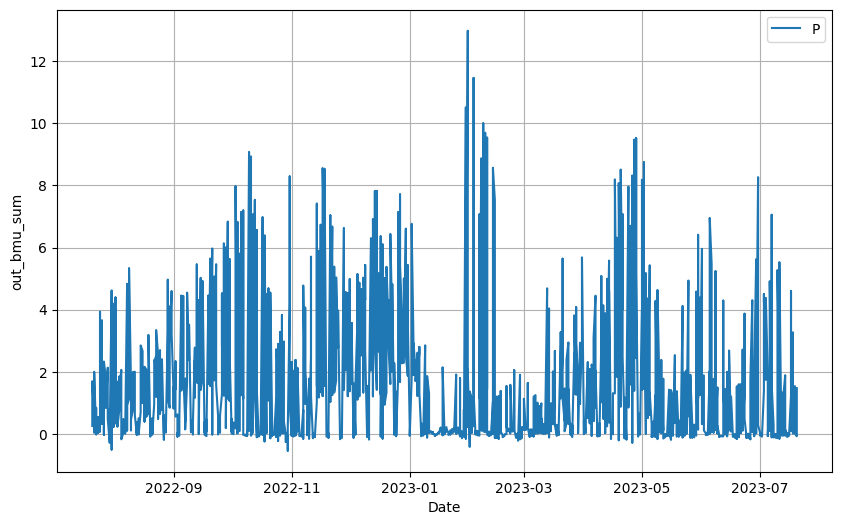

In [52]:
fig = plt.figure(figsize=(10, 6))
plt.plot(pd.Series(df_pred["out_bmu_sum"], index=df_pred.index))
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend(labels="Pred")
plt.grid()
plt.show()

In [53]:
df_pred.reset_index(inplace=True)
df_pred = (
    df_pred.groupby(
        df_pred["posting_date"].dt.to_period("m"),
        as_index=True,
    )
    .agg(
        out_bmu_sum=("out_bmu_sum", "sum"),
    )
    .reset_index()
)

In [54]:
df_pred.to_csv("prediction.csv", index=False)
df_pred

,posting_date,out_bmu_sum
0,2022-07,32.990954
1,2022-08,127.564866
2,2022-09,178.884346
3,2022-10,162.912478
4,2022-11,188.658085
5,2022-12,284.612212
6,2023-01,81.501473
7,2023-02,96.647200
8,2023-03,91.799298
9,2023-04,204.817503
